# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lectures. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ml/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ml/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ml/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ml/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ml/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [3]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
import jovian

<IPython.core.display.Javascript object>

In [4]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

In [5]:
your_name = 'Jhonathan' # at least 5 characters

In [6]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [7]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [8]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
676,55,female,42.4424,3,no,southeast,13859.238999
217,27,male,24.0240,0,no,southeast,2756.946960
864,51,male,26.4160,0,no,southwest,9748.540590
751,21,male,30.1340,0,no,northwest,2116.057658
1106,49,female,31.1220,0,no,northwest,9976.856213


**Let's check the complete dataframe, here there are information**

### Information about our dataset.

In [69]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1271 entries, 676 to 1115
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1271 non-null   int64  
 1   sex       1271 non-null   object 
 2   bmi       1271 non-null   float64
 3   children  1271 non-null   int64  
 4   smoker    1271 non-null   object 
 5   region    1271 non-null   object 
 6   charges   1271 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 79.4+ KB


**Q: How many rows does the dataset have?**

In [16]:
num_rows = dataframe.shape[0]
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [15]:
num_cols = dataframe.shape[1]
print(num_cols)

7


**Q: What are the column titles of the input variables?**

In [71]:
input_cols = dataframe.columns.to_list()
input_cols.remove('charges')
input_cols

['age', 'sex', 'bmi', 'children', 'smoker', 'region']

**Q: Which of the input columns are non-numeric or categorial variables ?**



In [37]:
categorical_cols = [x for x in dataframe.columns.to_list() if dataframe[x].dtype == 'object']
categorical_cols

['sex', 'smoker', 'region']

Q: (Optional) What is the minimum, maximum and average value of the charges column? Can you show the distribution of values in a graph? Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

Q: What are the column titles of output/target variable(s)?

In [70]:
output_cols = ['charges']

#### Q: (Optional) What is the minimum, maximum and average value of the charges column? 
Can you show the distribution of values in a graph? Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [68]:

#Searching the max value into BMI column
max_value = dataframe['charges'].max()
print('Max value for charges: ', max_value)

#Searching the min value into BMI column
min_value = dataframe['charges'].min()
print('Min value for charges: ', min_value)

## The max value for BMI is 55.2552, while thw min value is 16.5984

Max value for charges:  70785.1750911
Min value for charges:  1245.280029


Now, we can see de data distribution for charges with `Seaborn` library for database with `distpolot` only need the input and in this case our input is `BMI` column.

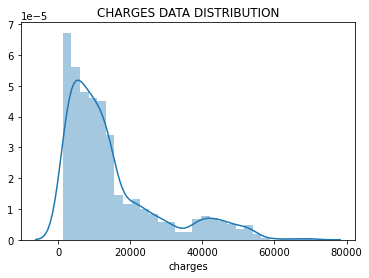

In [39]:
import seaborn as sns

sns.distplot(dataframe['charges'])
plt.title('CHARGES DATA DISTRIBUTION')
plt.show()


#### Correlation Matrix

We can compute easy the linear relation between all features in our dataset. Why? When we work with those algorithm like Classic Machine learning y useful to know more about the data. Then, With the correlation matrix we will know if the data has some linear relationship betweet features. The correlation usually is from -1 to 1 or 0 to 1 where 1 is a high correlation betweet features. 

This is a easy way to know our data bou dont the unique.

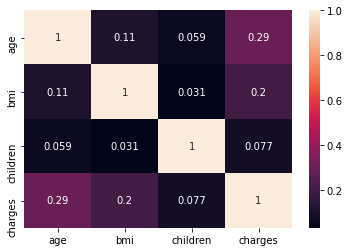

In [40]:
sns.heatmap(dataframe.corr(), annot=True) 
plt.show()

In [41]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit
jovian.commit(project=project_name, envoirement=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Updating notebook "jhonathanortiz/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ml/jhonathanortiz/02-insurance-linear-regression


'https://jovian.ml/jhonathanortiz/02-insurance-linear-regression'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [43]:
def dataframe_to_array(dataframe):
    
    dataframe1 = dataframe.copy()
    #Convert categorical data to numbers
    for cols in categorical_cols:
        dataframe1[cols] = dataframe[cols].astype('category').cat.codes

    #From data frame to numpy array
    inputs = dataframe1.drop('charges', axis=1).values
    target = dataframe1[['charges']].values

    return inputs, target


In [44]:
inputs_array, targets_array = dataframe_to_array(dataframe)

print(inputs_array.shape, targets_array.shape)

(1271, 6) (1271, 1)


### Converting numpy ndarray to Torch Tensor

In [45]:
inputs = torch.tensor(inputs_array, dtype=torch.float32)

targets = torch.tensor(targets_array, dtype=torch.float32)

#### Verify  data type

In [46]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a TensorDataset.

In [47]:
dataset = TensorDataset(inputs,targets)

In [50]:
val_percent = 0.2 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = (num_rows - val_size)


train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(1017, 254)

### Finally, we can create data loaders for training & validation.

Q: Pick a batch size for the data loader.

In [58]:
batch_size = 10

In [64]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [65]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[20.0000,  1.0000, 31.3196,  5.0000,  0.0000,  0.0000],
        [41.0000,  1.0000, 37.1800,  1.0000,  1.0000,  2.0000],
        [21.0000,  1.0000, 32.2608,  0.0000,  0.0000,  2.0000],
        [33.0000,  1.0000, 30.5760,  4.0000,  0.0000,  3.0000],
        [43.0000,  0.0000, 31.0960,  1.0000,  0.0000,  3.0000],
        [18.0000,  1.0000, 29.4424,  1.0000,  0.0000,  0.0000],
        [49.0000,  0.0000, 38.0952,  3.0000,  0.0000,  2.0000],
        [36.0000,  1.0000, 36.6080,  1.0000,  1.0000,  2.0000],
        [43.0000,  0.0000, 31.9124,  2.0000,  0.0000,  1.0000],
        [24.0000,  1.0000, 32.3076,  0.0000,  1.0000,  0.0000]])
targets: tensor([[ 5455.7163],
        [44703.7461],
        [18411.0117],
        [ 6725.6821],
        [ 8144.9004],
        [12512.2881],
        [11523.4414],
        [42967.1836],
        [ 9225.0312],
        [38022.0000]])


### Step 3: Create a Linear Regression Model
Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment).


In [72]:
input_size = len(input_cols)
output_size = len(output_cols)

input_size, output_size

(6, 1)

In [170]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        #Define linear pytorch method returns the input weighted sum like y = wx + b
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        output = self.linear(x)
        return output
    
    def training_step(self, batch):
        inputs, targets = batch
        #Make prediction
        prediction = self(inputs)
        #Compute loss
        loss = F.l1_loss(prediction, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                           # fill this    
        return {'val_loss': loss.detach()}

    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))
            
        

Let us create a model using the InsuranceModel class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes nan or infinity.

In [142]:
model = InsuranceModel()

In [143]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.2523, -0.0578,  0.0197, -0.2097, -0.4010, -0.2816]],
        requires_grad=True),
 Parameter containing:
 tensor([0.1865], requires_grad=True)]

In [171]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


#Train loop
def fit(epochs, lr, model, train_batch, val_batch, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_batch:
            loss = model.train_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #val_step
        result = evaluate(model, val_batch)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
        return history

In [164]:
result = evaluate(model, val_dataset) # Use the the evaluate function
print(result)

{'val_loss': 8913.291015625}


We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or nan), you may have to re-initialize the model by running the cell model = InsuranceModel(). Experiment with this for a while, and try to get to as low a loss as possible.

##### Q: Train the model 4-5 times with different learning rates & for different number of epochs.

Hint: Vary learning rates by orders of 10 (e.g. 1e-2, 1e-3, 1e-4, 1e-5, 1e-6) to figure out what works.

In [172]:
model = InsuranceModel()
epochs = 1000
lr = 1e-1
history1= fit(epochs, lr, model, train_loader, val_loader)


Epoch [20], val_loss: 8395.3682
Epoch [40], val_loss: 8358.2324
Epoch [60], val_loss: 8330.6309
Epoch [80], val_loss: 8307.0508
Epoch [100], val_loss: 8288.4775
Epoch [120], val_loss: 8273.1895
Epoch [140], val_loss: 8250.2041
Epoch [160], val_loss: 8242.5010
Epoch [180], val_loss: 8220.5156
Epoch [200], val_loss: 8205.6816
Epoch [220], val_loss: 8188.8472
Epoch [240], val_loss: 8190.5293
Epoch [260], val_loss: 8166.0190
Epoch [280], val_loss: 8160.9209
Epoch [300], val_loss: 8136.3291
Epoch [320], val_loss: 8123.3838
Epoch [340], val_loss: 8111.0503
Epoch [360], val_loss: 8099.4478
Epoch [380], val_loss: 8087.2729
Epoch [400], val_loss: 8082.2007
Epoch [420], val_loss: 8062.7788
Epoch [440], val_loss: 8052.4443
Epoch [460], val_loss: 8054.6841
Epoch [480], val_loss: 8028.5464
Epoch [500], val_loss: 8029.0991
Epoch [520], val_loss: 8007.8535
Epoch [540], val_loss: 8013.6240
Epoch [560], val_loss: 7985.7896
Epoch [580], val_loss: 7980.6230
Epoch [600], val_loss: 7961.7725
Epoch [620], v

In [173]:
epochs = 1500
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7751.5073
Epoch [40], val_loss: 7751.4473
Epoch [60], val_loss: 7751.3428
Epoch [80], val_loss: 7751.3237
Epoch [100], val_loss: 7750.9404
Epoch [120], val_loss: 7750.8350
Epoch [140], val_loss: 7750.7925
Epoch [160], val_loss: 7750.7031
Epoch [180], val_loss: 7750.6274
Epoch [200], val_loss: 7750.4956
Epoch [220], val_loss: 7750.4482
Epoch [240], val_loss: 7750.2480
Epoch [260], val_loss: 7750.0522
Epoch [280], val_loss: 7750.0166
Epoch [300], val_loss: 7749.9136
Epoch [320], val_loss: 7749.8481
Epoch [340], val_loss: 7749.7627
Epoch [360], val_loss: 7749.5601
Epoch [380], val_loss: 7749.5815
Epoch [400], val_loss: 7749.4604
Epoch [420], val_loss: 7749.4287
Epoch [440], val_loss: 7749.1128
Epoch [460], val_loss: 7749.0493
Epoch [480], val_loss: 7748.9463
Epoch [500], val_loss: 7748.9082
Epoch [520], val_loss: 7748.7803
Epoch [540], val_loss: 7748.7471
Epoch [560], val_loss: 7748.4141
Epoch [580], val_loss: 7748.5542
Epoch [600], val_loss: 7748.4072
Epoch [620], v

In [174]:
epochs = 1000
lr = 1e-3
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7743.2549
Epoch [40], val_loss: 7743.3721
Epoch [60], val_loss: 7743.1060
Epoch [80], val_loss: 7743.0972
Epoch [100], val_loss: 7742.7993
Epoch [120], val_loss: 7742.7822
Epoch [140], val_loss: 7742.6934
Epoch [160], val_loss: 7742.8613
Epoch [180], val_loss: 7742.5601
Epoch [200], val_loss: 7742.5083
Epoch [220], val_loss: 7742.4810
Epoch [240], val_loss: 7742.2500
Epoch [260], val_loss: 7742.2056
Epoch [280], val_loss: 7742.2026
Epoch [300], val_loss: 7742.0347
Epoch [320], val_loss: 7742.0200
Epoch [340], val_loss: 7741.9683
Epoch [360], val_loss: 7741.7578
Epoch [380], val_loss: 7741.7500
Epoch [400], val_loss: 7741.7188
Epoch [420], val_loss: 7741.3066
Epoch [440], val_loss: 7741.4043
Epoch [460], val_loss: 7741.3237
Epoch [480], val_loss: 7741.3691
Epoch [500], val_loss: 7740.9385
Epoch [520], val_loss: 7741.0947
Epoch [540], val_loss: 7740.9453
Epoch [560], val_loss: 7740.6245
Epoch [580], val_loss: 7740.7808
Epoch [600], val_loss: 7740.8447
Epoch [620], v

In [175]:
epochs = 1000
lr = 1e-4
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7738.7319
Epoch [40], val_loss: 7738.7256
Epoch [60], val_loss: 7738.7310
Epoch [80], val_loss: 7738.7300
Epoch [100], val_loss: 7738.7339
Epoch [120], val_loss: 7738.7417
Epoch [140], val_loss: 7738.7314
Epoch [160], val_loss: 7738.7339
Epoch [180], val_loss: 7738.7271
Epoch [200], val_loss: 7738.7310
Epoch [220], val_loss: 7738.7349
Epoch [240], val_loss: 7738.7222
Epoch [260], val_loss: 7738.7339
Epoch [280], val_loss: 7738.7334
Epoch [300], val_loss: 7738.7354
Epoch [320], val_loss: 7738.7231
Epoch [340], val_loss: 7738.7300
Epoch [360], val_loss: 7738.7139
Epoch [380], val_loss: 7738.7290
Epoch [400], val_loss: 7738.7231
Epoch [420], val_loss: 7738.7256
Epoch [440], val_loss: 7738.7295
Epoch [460], val_loss: 7738.7334
Epoch [480], val_loss: 7738.7158
Epoch [500], val_loss: 7738.7285
Epoch [520], val_loss: 7738.7256
Epoch [540], val_loss: 7738.7163
Epoch [560], val_loss: 7738.7231
Epoch [580], val_loss: 7738.7139
Epoch [600], val_loss: 7738.7075
Epoch [620], v

In [176]:
epochs = 250
lr = 1e-6
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7738.6997
Epoch [40], val_loss: 7738.7007
Epoch [60], val_loss: 7738.7012
Epoch [80], val_loss: 7738.7007
Epoch [100], val_loss: 7738.7026
Epoch [120], val_loss: 7738.7012
Epoch [140], val_loss: 7738.7002
Epoch [160], val_loss: 7738.7007
Epoch [180], val_loss: 7738.7007
Epoch [200], val_loss: 7738.7007
Epoch [220], val_loss: 7738.7002
Epoch [240], val_loss: 7738.6997
Epoch [250], val_loss: 7738.6997


### Q: What is the final validation loss of your model?

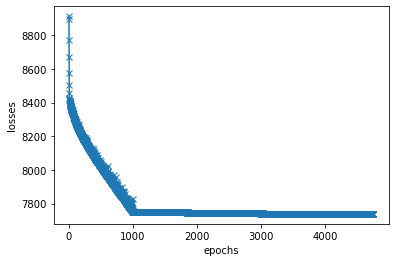

In [179]:
val_loss = [result] + history1 + history2 + history3 + history4 + history5
#print(val_loss)
val_loss_list = [vl['val_loss'] for vl in val_loss]

plt.plot(val_loss_list, '-x')

plt.xlabel('epochs')
plt.ylabel('losses')
plt.show()

In [189]:
x = torch.rand((2, 3, 3))
print(x.size())


torch.Size([2, 3, 3])


torch.Size([2, 1, 3, 3])

In [204]:
def predict_single(inputs, target, model):
    inp = inputs.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions.detach()
    print('Input: ', inputs)
    print('Target: ', target)
    print('Prediction: ',  prediction)

In [205]:
inputs, target = val_ds[0]
predict_single(inputs, target, model)

torch.Size([6])
torch.Size([1, 6])
Input:  tensor([55.0000,  0.0000, 31.7200,  0.0000,  0.0000,  3.0000])
Target:  tensor([11881.9619])
Prediction:  tensor([11915.9883])


In [206]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "jhonathanortiz/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/jhonathanortiz/02-insurance-linear-regression


'https://jovian.ml/jhonathanortiz/02-insurance-linear-regression'

Are you happy with your model's predictions? Try to improve them further.

> ## (Optional) Step 6: Try another dataset & blog about it
While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to clean up & replicate this notebook (or this one, or this one ) for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patters in machine learning from problem-specific details.

Here are some sources to find good datasets:

https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
https://www.kaggle.com/rtatman/datasets-for-regression-analysis
https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
https://archive.ics.uci.edu/ml/datasets/wine+quality
https://pytorch.org/docs/stable/torchvision/datasets.html
We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

* Interesting title & subtitle
* Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
* Downloading & exploring the data
* Preparing the data for training
* Creating a model using PyTorch
* Training the model to fit the data
* Your thoughts on how to experiment with different hyperparmeters to reduce loss
* Making predictions using the model
* As with the previous assignment, you can embed Juptyer notebook cells & outputs from Jovian into your blog.

Don't forget to share your work on the forum: https://jovian.ml/forum/t/share-your-work-here-assignment-2/4931

In [207]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "jhonathanortiz/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/jhonathanortiz/02-insurance-linear-regression


'https://jovian.ml/jhonathanortiz/02-insurance-linear-regression'

In [208]:
!git init

Initialized empty Git repository in /kaggle/working/.git/


In [223]:
!git add -A


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@8431af09b493.(none)')
